# Лабораторная работа 10


In [1]:
import numpy as np                # импорт бибилиотеки numpy
import matplotlib.pyplot as plt   # импорт модуля matplotlib.pyplot
import scipy.integrate as integrate # импорт модуля численного интегрирования
import sympy as sym
import scipy as sp
import scipy.optimize as op
import pandas as pd
import copy
import numbers
import math
from scipy.optimize import fsolve
from scipy.integrate import solve_ivp
from scipy.optimize import root_scalar

from typing import Callable
import os
import sys
import git
repo = git.Repo('.', search_parent_directories=True)
library_dir = repo.working_tree_dir + '/lib'
sys.path.insert(0, library_dir)

import miptlib as mipt

# Create directory for generated .tex and .pdf
if not os.path.exists('gen'):
    os.mkdir('gen')

### Задача:

предъявить численное решение уравнения переноса и сравнить его с аналитическим (постановку аналитической задачи найти самостоятельно): 
 - использовать схемы для численного решения: уголок, прямоугольник, Лакс-Вендрофф (Явная четырехточечная схема)
- провести исследование на сходимость (сравнение численного и аналитического решения)
- провести анализ порядка аппроксимации (сходимости) (график с убыванием нормы ошибки в зависимости от шага интегрирования в логарифмическом масштабе)

In [13]:
def calculate_step_central_three_point(u_k_curr, u_k_next, M, h, tau, a, current_t, f_source):
    for m_idx in range(1, M):
        term_avg_space = 0.5 * (u_k_curr[m_idx + 1] + u_k_curr[m_idx - 1])
        term_transport = (tau * a / (2 * h)) * (u_k_curr[m_idx + 1] - u_k_curr[m_idx - 1])
        term_source_eval = tau * f_source(current_t, m_idx * h)
        u_k_next[m_idx] = term_avg_space - term_transport + term_source_eval

def calculate_step_corner(u_k_curr, u_k_next, M, h, tau, a, current_t, f_source):
    for m_idx in range(1, M + 1):
        u_k_next[m_idx] = u_k_curr[m_idx] - a * (tau / h) * \
                           (u_k_curr[m_idx] - u_k_curr[m_idx - 1]) + \
                           tau * f_source(current_t, m_idx * h)

def calculate_step_lax_wendroff(u_k_curr, u_k_next, M, h, tau, a, current_t, f_source):
    for m_idx in range(1, M):
        term_transport = a * (tau / (2 * h)) * (u_k_curr[m_idx + 1] - u_k_curr[m_idx - 1])
        term_diffusion_like = (0.5 * tau * tau / (h * h)) * \
                              (u_k_curr[m_idx + 1] - 2 * u_k_curr[m_idx] + u_k_curr[m_idx - 1])
        term_source_eval = tau * f_source(current_t, m_idx * h)
        u_k_next[m_idx] = u_k_curr[m_idx] - term_transport + term_diffusion_like + term_source_eval

def calculate_step_rectangle(u_k_curr, u_k_next, M, h, tau, a, current_t, f_source):
    C1 = 1.0 / (2.0 * tau)
    C2 = a / (2.0 * h)
    
    coeff_A = C1 - C2 
    coeff_B = C1 + C2 

    if abs(coeff_B) < 1e-15:
        for m_idx in range(1, M + 1): u_k_next[m_idx] = float('nan')
        return

    for m_idx in range(1, M + 1):
        f_avg = f_source(current_t + tau / 2.0, (m_idx - 0.5) * h) 
        
        rhs_val = (C1 + C2) * u_k_curr[m_idx - 1] + \
                    (C1 - C2) * u_k_curr[m_idx] + \
                    f_avg
        
        u_k_next[m_idx] = (rhs_val - coeff_A * u_k_next[m_idx - 1]) / coeff_B


def solve_transport_sequential_schemes(
    X: float, T: float, M: int, K: int, a: float,
    phi: Callable[[float], float],
    psi: Callable[[float], float],
    f_source: Callable[[float, float], float],
    scheme_name: str = "central-three-point",
    comm=None 
):
    u = np.zeros((K + 1, M + 1))
    h = X / M
    tau = T / K

    for m_idx in range(M + 1):
        u[0, m_idx] = phi(m_idx * h)

    for k_idx in range(K):
        current_t_for_source = k_idx * tau
        
        u[k_idx + 1, 0] = psi((k_idx + 1) * tau)

        u_k_curr_slice = u[k_idx, :]
        u_k_next_slice = u[k_idx + 1, :]

        if scheme_name == "central-three-point":
            calculate_step_central_three_point(u_k_curr_slice, u_k_next_slice, M, h, tau, a, current_t_for_source, f_source)
            if M > 1:
                u[k_idx + 1, M] = 2 * u[k_idx + 1, M - 1] - u[k_idx + 1, M - 2]
            elif M == 1:
                 u[k_idx + 1, M] = u[k_idx + 1, 0]
        elif scheme_name == "corner":
            calculate_step_corner(u_k_curr_slice, u_k_next_slice, M, h, tau, a, current_t_for_source, f_source)
        elif scheme_name == "lax-wendroff":
            calculate_step_lax_wendroff(u_k_curr_slice, u_k_next_slice, M, h, tau, a, current_t_for_source, f_source)
            if M > 1:
                u[k_idx + 1, M] = 2 * u[k_idx + 1, M - 1] - u[k_idx + 1, M - 2]
            elif M == 1:
                 u[k_idx + 1, M] = u[k_idx+1,0]
        elif scheme_name == "rectangle":
            calculate_step_rectangle(u_k_curr_slice, u_k_next_slice, M, h, tau, a, current_t_for_source, f_source)
        else:
            raise ValueError(f"Unknown scheme_name: {scheme_name}")
            
    return u

In [14]:
def mms_convergence_study(
    X: float, T: float, M: int, K: int, a: float,
    u_exact_func: Callable[[float, float], float],
    solver_func: Callable = solve_transport_sequential_schemes,
    scheme: str = "central-three-point"
) -> tuple[float, float]:
    h = X / M
    tau = T / K

    delta_t = 1e-8 
    delta_x = 1e-8

    du_dt_lambda = lambda t_val, x_val: (u_exact_func(t_val + delta_t, x_val) - u_exact_func(t_val - delta_t, x_val)) / (2 * delta_t)
    du_dx_lambda = lambda t_val, x_val: (u_exact_func(t_val, x_val + delta_x) - u_exact_func(t_val, x_val - delta_x)) / (2 * delta_x)

    f_mms_lambda = lambda t_val, x_val: du_dt_lambda(t_val, x_val) + a * du_dx_lambda(t_val, x_val)
    phi_mms_lambda = lambda x_val: u_exact_func(0, x_val)
    psi_mms_lambda = lambda t_val: u_exact_func(t_val, 0)

    u_numerical = solver_func(X, T, M, K, a, phi_mms_lambda, psi_mms_lambda, f_mms_lambda, scheme)

    u_exact_final_t = np.zeros(M + 1)
    for m_idx in range(M + 1):
        u_exact_final_t[m_idx] = u_exact_func(T, m_idx * h)

    u_numerical_final_t = u_numerical[K, :]

    norm_u_exact = np.linalg.norm(u_exact_final_t)
    if norm_u_exact < 1e-15:
        l2_error = np.linalg.norm(u_numerical_final_t - u_exact_final_t)
    else:
        l2_error = np.linalg.norm(u_numerical_final_t - u_exact_final_t) / norm_u_exact

    return l2_error

In [19]:
def analyze_approximation_order_spatial(
    X: float, T: float, a: float,
    u_exact_func: Callable[[float, float], float],
    M_values: list[int],
    solver_func: Callable = solve_transport_sequential_schemes,
    scheme: str = "central-three-point" ,
    cfl_target: float = 0.5
):
    h_values = []
    l2_errors = []

    for M_val in M_values:
        h = X / M_val
        if a == 0:
            K_val = M_val * 2
        else:
            K_val = math.ceil((T * abs(a)) / (cfl_target * h))

        tau = T / K_val

        h_values.append(h)
        l2_err= mms_convergence_study(X, T, M_val, K_val, a, u_exact_func, solver_func, scheme)
        l2_errors.append(l2_err)

    h_values = np.array(h_values)
    l2_errors = np.array(l2_errors)
    
    if len(h_values) >= 2:
        if l2_errors[-1] > 0 and l2_errors[-2] > 0 :
            p_l2 = (math.log(l2_errors[-1]) - math.log(l2_errors[-2])) / \
                   (math.log(h_values[-1]) - math.log(h_values[-2]))
            print(f"\nПорядок сходимости по двум точкам: {p_l2:.2f}")
        else:
            print("error, ", l2_errors[-1] > 0, l2_errors[-2] > 0)

    plt.figure(figsize=(10, 6))
    plt.loglog(h_values, l2_errors, 'o-', label='L2 Error')

    if len(h_values) > 0 and l2_errors[0] > 0 :
        C1 = l2_errors[0] / h_values[0]
        plt.loglog(h_values, C1 * h_values, 'k:', label='O(h)')
        C2 = l2_errors[0] / (h_values[0]**2)
        plt.loglog(h_values, C2 * (h_values**2), 'k-.', label='O(h^2)')

    plt.xlabel('шаг h')
    plt.ylabel('Норма ошибки')
    plt.title(f'Анализ порядка аппроксимации {scheme}')
    plt.grid(True, which="both", ls="-")
    plt.legend()
    plt.show()

M=100, K=32:
  L2 Error: 5.8908e-02

Порядок сходимости по двум точкам: 1.00


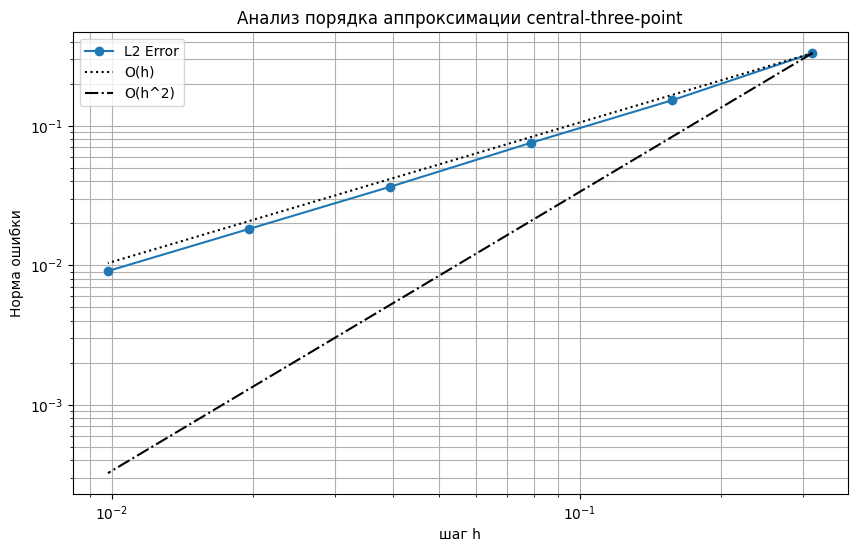

M=100, K=32:
  L2 Error: 2.0632e-02

Порядок сходимости по двум точкам: 1.01


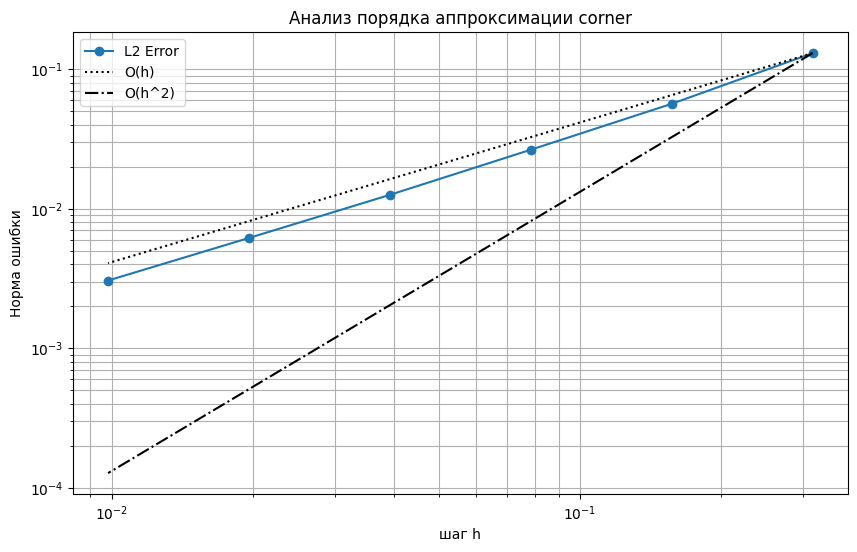

M=100, K=32:
  L2 Error: 9.2869e-04

Порядок сходимости по двум точкам: 2.01


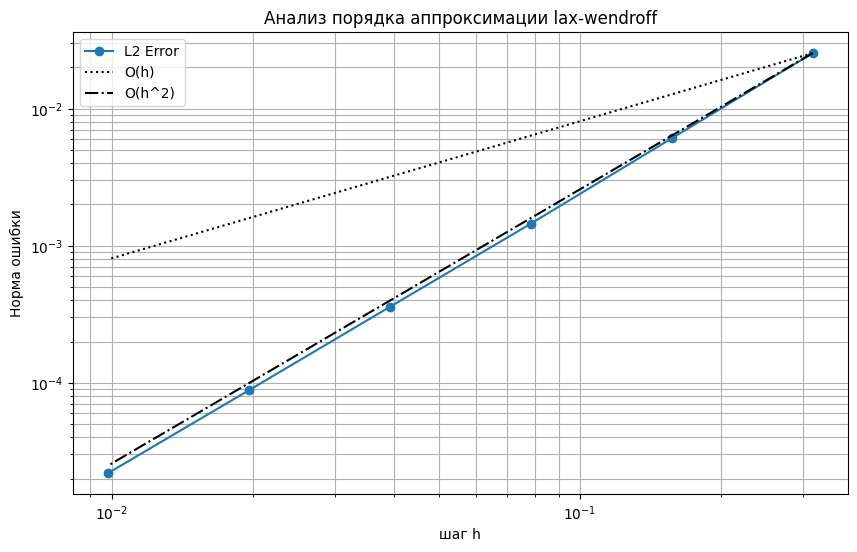

M=100, K=32:
  L2 Error: 2.0946e-03

Порядок сходимости по двум точкам: 2.00


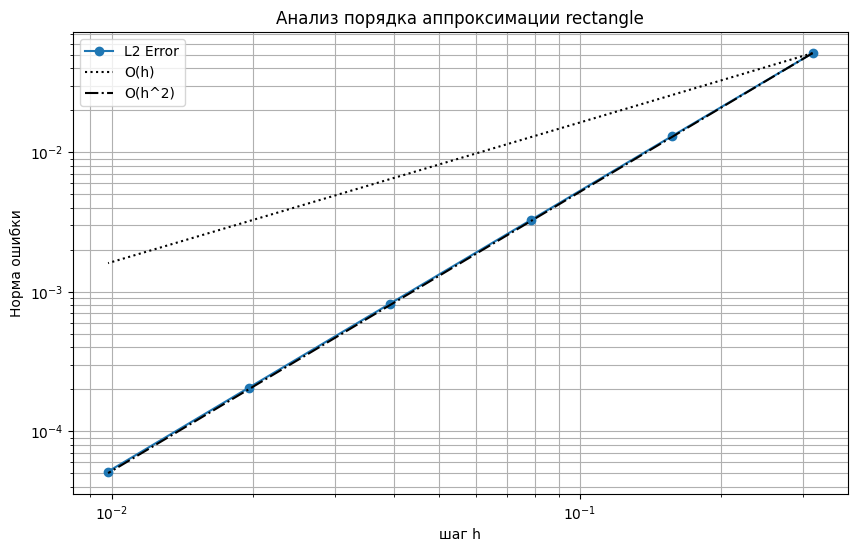

In [20]:
X_param = 2.0 * np.pi
T_param = 1.0
a_param = 1.0

u_exact = lambda t, x: np.sin(x - a_param * t) + np.cos(x + a_param * t)

M_single = 100
h_single = X_param / M_single
cfl_val = 0.5
K_single = math.ceil((T_param * abs(a_param)) / (cfl_val * h_single))

schemes_to_test = ["central-three-point", "corner", "lax-wendroff", "rectangle"]

for scheme in schemes_to_test:
    l2_err_single = mms_convergence_study(
        X_param, T_param, M_single, K_single, a_param, u_exact, solve_transport_sequential_schemes, scheme
    )
    print(f"M={M_single}, K={K_single}:")
    print(f"  L2 Error: {l2_err_single:.4e}")
    
    M_values_for_study = [20, 40, 80, 160, 320, 640]
    
    analyze_approximation_order_spatial(
        X_param, T_param, a_param, u_exact, M_values_for_study, solve_transport_sequential_schemes, scheme, cfl_target=cfl_val
    )